In [ ]:
##########################################################
# DSC5103 Statistics
# Session 9. Trees I
# 2016.12
#
# run decision tree using the tree() and cv.tree() function in the "tree" package
# demo for Regression trees
# using the Hitters dataset in package "ISLR"
##########################################################

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error

%matplotlib inline

In [2]:
## remove na values
df = pd.read_csv('Heart.csv').dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 15 columns):
Unnamed: 0    297 non-null int64
Age           297 non-null int64
Sex           297 non-null int64
ChestPain     297 non-null object
RestBP        297 non-null int64
Chol          297 non-null int64
Fbs           297 non-null int64
RestECG       297 non-null int64
MaxHR         297 non-null int64
ExAng         297 non-null int64
Oldpeak       297 non-null float64
Slope         297 non-null int64
Ca            297 non-null float64
Thal          297 non-null object
AHD           297 non-null object
dtypes: float64(2), int64(10), object(3)
memory usage: 37.1+ KB


In [3]:
print(df.head())

   Unnamed: 0  Age  Sex     ChestPain  RestBP  Chol  Fbs  RestECG  MaxHR  \
0           1   63    1       typical     145   233    1        2    150   
1           2   67    1  asymptomatic     160   286    0        2    108   
2           3   67    1  asymptomatic     120   229    0        2    129   
3           4   37    1    nonanginal     130   250    0        0    187   
4           5   41    0    nontypical     130   204    0        2    172   

   ExAng  Oldpeak  Slope   Ca        Thal  AHD  
0      0      2.3      3  0.0       fixed   No  
1      1      1.5      2  3.0      normal  Yes  
2      1      2.6      2  2.0  reversable  Yes  
3      0      3.5      3  0.0      normal   No  
4      0      1.4      1  0.0      normal   No  


In [4]:
df = df.drop('Unnamed: 0', axis=1)

In [5]:
df.ChestPain = pd.factorize(df.ChestPain)[0]
df.Thal = pd.factorize(df.Thal)[0]
df.AHD = df.AHD.map({'No':0, 'Yes':1})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
Age          297 non-null int64
Sex          297 non-null int64
ChestPain    297 non-null int64
RestBP       297 non-null int64
Chol         297 non-null int64
Fbs          297 non-null int64
RestECG      297 non-null int64
MaxHR        297 non-null int64
ExAng        297 non-null int64
Oldpeak      297 non-null float64
Slope        297 non-null int64
Ca           297 non-null float64
Thal         297 non-null int64
AHD          297 non-null int64
dtypes: float64(2), int64(12)
memory usage: 34.8 KB


In [41]:
# split training and test data 50/50
X = df.drop('AHD', axis=1)
y = df.AHD
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=1234)

In [42]:
## grow a tree
# choosing max nodes 7 (max leaves can be set as well)
clf = DecisionTreeClassifier(max_leaf_nodes=7)
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.8783783783783784

In [43]:
clfclass = np.asarray(clf.classes_, dtype=str)

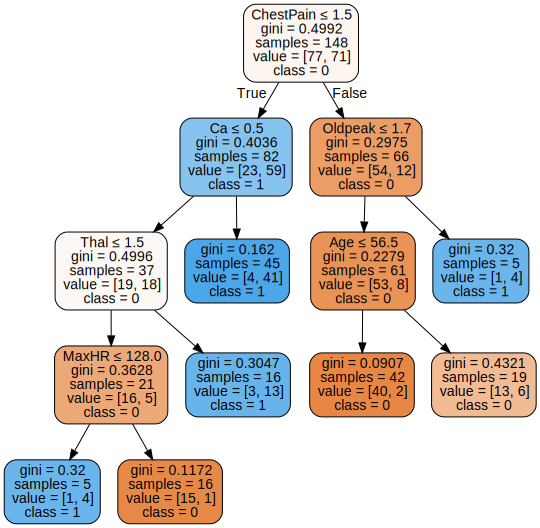

In [44]:
export_graphviz(clf, out_file="mytree.dot", feature_names=X_train.columns, class_names=clfclass, 
                filled=True, rounded=True, special_characters=True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [45]:
pred = clf.predict(X_test)
predprob = clf.predict_proba(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
print(cm)

     No  Yes
No   63   14
Yes  20   52


In [46]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds=roc_curve(y_test, predprob[:,1])

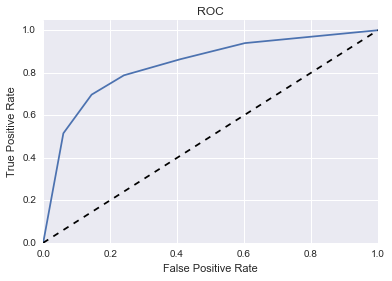

In [47]:
ax=plt.gca()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC')

In [48]:
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.836801752464


In [49]:
## pruning the tree with GridSearchCV
from sklearn.grid_search import GridSearchCV

In [50]:
clfpruned = DecisionTreeClassifier()

In [51]:
parameters = {'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8]}

In [52]:
# http://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(clfpruned, param_grid=parameters, scoring='f1', n_jobs=4, cv=10)
# Valid options are ['accuracy', 'adjusted_rand_score', 'average_precision', 'f1', 
# 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'log_loss', 'mean_absolute_error', 
# 'mean_squared_error', 'median_absolute_error', 'precision', 'precision_macro', 'precision_micro', 
# 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 
# 'recall_weighted', 'roc_auc']

In [53]:
gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [54]:
gs.grid_scores_

[mean: 0.61659, std: 0.10925, params: {'max_leaf_nodes': 2},
 mean: 0.65105, std: 0.16740, params: {'max_leaf_nodes': 3},
 mean: 0.71298, std: 0.10322, params: {'max_leaf_nodes': 4},
 mean: 0.72111, std: 0.09783, params: {'max_leaf_nodes': 5},
 mean: 0.73351, std: 0.05511, params: {'max_leaf_nodes': 6},
 mean: 0.72373, std: 0.07108, params: {'max_leaf_nodes': 7},
 mean: 0.73742, std: 0.06045, params: {'max_leaf_nodes': 8}]

In [55]:
print("BEST", gs.best_params_, gs.best_score_)

BEST {'max_leaf_nodes': 8} 0.737421296245


In [56]:
best = gs.best_estimator_  # the best model

In [57]:
best.fit(X_train, y_train)
print(best.score(X_train, y_train)) # training accuracy
print(best.score(X_test, y_test)) # test accuracy

0.878378378378
0.771812080537


In [58]:
clfbestclass = np.asarray(best.classes_, dtype=str)

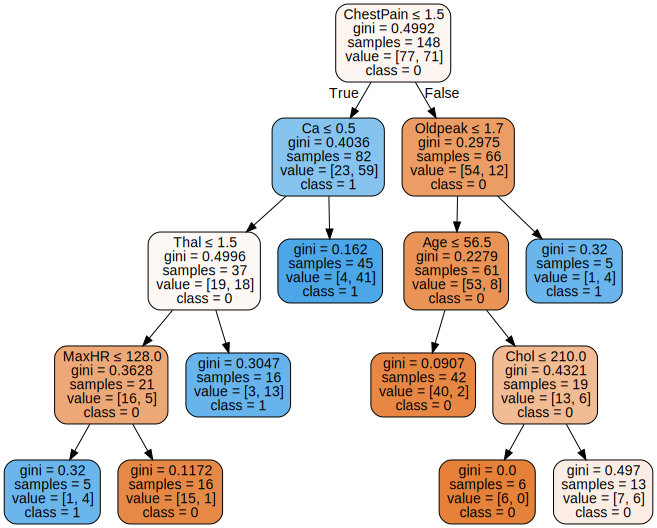

In [59]:
export_graphviz(best, out_file="mytree.dot", feature_names=X_train.columns, class_names=clfclass, 
                filled=True, rounded=True, special_characters=True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [60]:
predbest = best.predict(X_test)
predprobbest = best.predict_proba(X_test)
cmbest = pd.DataFrame(confusion_matrix(y_test, predbest).T, index=['No', 'Yes'], columns=['No', 'Yes'])
print(cmbest)

     No  Yes
No   63   14
Yes  20   52


In [61]:
fpr1, tpr1, thresholds1=roc_curve(y_test, predprobbest[:,1])

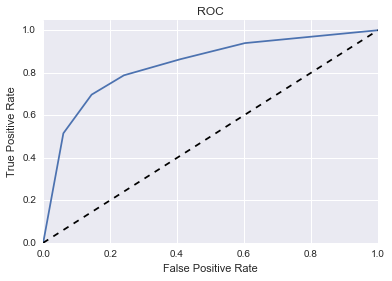

In [62]:
ax=plt.gca()
ax.plot(fpr1, tpr1)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC')

In [63]:
roc_auc = auc(fpr1, tpr1)
print(roc_auc)

0.836801752464
